### Choose GPU settings, import libraries

In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
num_GPU = len(os.environ["CUDA_VISIBLE_DEVICES"].split(',')) 

import tensorflow as tf
import keras
from keras import backend as K
from keras.datasets import mnist

from keras.layers import Conv2D, MaxPool2D
from keras.models import Sequential
from keras.utils import to_categorical, multi_gpu_model, plot_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model

config = tf.ConfigProto() 
config.gpu_options.allow_growth=True 
session = tf.Session(config=config)
K.set_session(session)



Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from tqdm import tqdm_notebook as tqdm
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

import keras_helper
from keras_helper import *
from skimage.transform import resize

### Some training parameters

In [3]:
h,w=64,64
nepochs=75
wt_path = 'wts4' #Where to store network weights
batch_size = 32

if (not os.path.isdir(wt_path)):
    os.mkdir(wt_path)

### Read experimental diffraction data and reconstructed images

In [4]:
data_diffr = np.load('data/20191008_39_diff.npz')['arr_0']

In [5]:
print(data_diffr.shape)
#plt.matshow(np.log10(data_diffr[0,0]))

data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), float)
for i in tqdm(range(data_diffr.shape[0])):
    for j in range(data_diffr.shape[1]):
        data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
        data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])


(161, 161, 256, 256)


In [6]:
#amp = np.load('../expt_data/s26_data/20191008_30_10nm_amp.npz')['arr_0']
#ph = np.load('../expt_data/s26_data/20191008_39_10nm.npz')['arr_0']
real_space = np.load('../expt_data/s26_data/20191008_39_amp_pha_10nm_full.npy')
amp = np.abs(real_space)
ph = np.angle(real_space)
amp.shape

(161, 161, 64, 64)

W0609 23:03:22.267590 140165287601984 font_manager.py:1282] findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


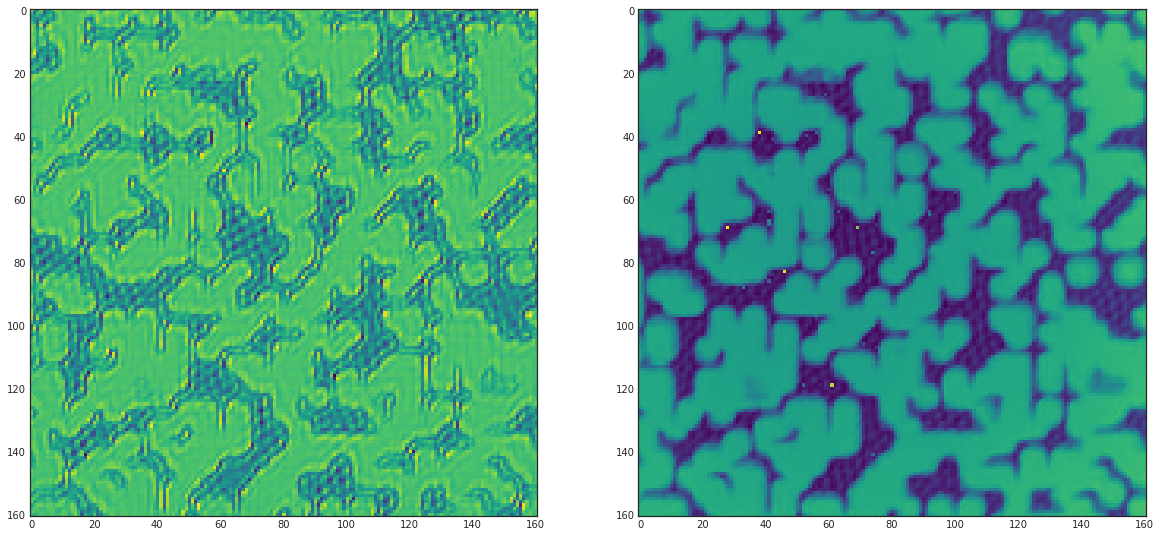

In [7]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(amp[:,:,32,32])
ax[1].imshow(ph[:,:,32,32])

### Split data and then shuffle

In [8]:
nlines = 100 #How many lines of data to use for training?
nltest = 60 #How many lines for the test set?
tst_strt = amp.shape[0]-nltest #Where to index from
print(tst_strt)

101


In [9]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


X_train = data_diffr_red[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_I_train = amp[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_phi_train = ph[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]

ntrain = X_train.shape[0]*X_train.shape[1]
ntest = X_test.shape[0]*X_test.shape[1]

print(X_train.shape, X_test.shape)

X_train, Y_I_train, Y_phi_train = shuffle(X_train, Y_I_train, Y_phi_train, random_state=0)

(16100, 64, 64, 1) (3600, 64, 64, 1)


### Save the test data for later use

In [10]:
np.save('data/X_test.npy', X_test) #Diffraction data
np.save('data/Y_I_test.npy', Y_I_test) #Intensity data
np.save('data/Y_phi_test.npy', Y_phi_test) #Intensity data

## Define the network structure

In [11]:

K.clear_session()
np.random.seed(123)
model=Sequential()

files=glob.glob('%s/*' %wt_path)
for file in files:
    os.remove(file)


input_img = Input(shape=(h, w, 1)) 

x = Conv_Pool_block(input_img,32,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
x = Conv_Pool_block(x,64,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
x = Conv_Pool_block(x,128,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
#Activations are all ReLu

encoded=x

#Decoding arm 1
x1=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x1=Conv_Up_block(x1,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x1=Conv_Up_block(x1,32,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')

decoded1 = Conv2D(1, (3, 3), padding='same')(x1)


#Decoding arm 2
x2=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x2=Conv_Up_block(x2,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x2=Conv_Up_block(x2,32,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')

decoded2 = Conv2D(1, (3, 3), padding='same')(x2)

#Put together
autoencoder = Model(input_img, [decoded1, decoded2])
parallel_model = ModelMGPU(autoencoder, gpus=num_GPU)
parallel_model.compile(optimizer='adam', loss='mean_absolute_error')

print (autoencoder.summary())
#plot_model(autoencoder, to_file='paper_data/str_model.png')


W0609 23:03:24.084986 140165287601984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0609 23:03:24.086560 140165287601984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0609 23:03:24.091528 140165287601984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0609 23:03:24.094970 140165287601984 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W060

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [12]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.0001, verbose=1)

checkpoints=keras.callbacks.ModelCheckpoint('%s/weights.{epoch:02d}.hdf5' %wt_path, 
                                            monitor='val_loss', verbose=1, save_best_only=True, 
                                            save_weights_only=False, mode='auto', period=1)

history=parallel_model.fit(X_train, [Y_I_train, Y_phi_train], shuffle=True, batch_size=batch_size, verbose=1, 
                           epochs=nepochs, validation_split = 0.05, callbacks=[checkpoints, reduce_lr])

Train on 15295 samples, validate on 805 samples
Epoch 1/75
15295/15295 [==============================] - 16s 1ms/step - loss: 0.6867 - conv2d_13_loss: 0.0408 - conv2d_20_loss: 0.6459 - val_loss: 0.4768 - val_conv2d_13_loss: 0.0075 - val_conv2d_20_loss: 0.4693

Epoch 00001: val_loss improved from inf to 0.47680, saving model to wts4/weights.01.hdf5
Epoch 2/75
15295/15295 [==============================] - 14s 884us/step - loss: 0.4574 - conv2d_13_loss: 0.0073 - conv2d_20_loss: 0.4501 - val_loss: 0.4283 - val_conv2d_13_loss: 0.0068 - val_conv2d_20_loss: 0.4215

Epoch 00002: val_loss improved from 0.47680 to 0.42832, saving model to wts4/weights.02.hdf5
Epoch 3/75
15295/15295 [==============================] - 12s 801us/step - loss: 0.3968 - conv2d_13_loss: 0.0067 - conv2d_20_loss: 0.3901 - val_loss: 0.3754 - val_conv2d_13_loss: 0.0065 - val_conv2d_20_loss: 0.3689

Epoch 00003: val_loss improved from 0.42832 to 0.37540, saving model to wts4/weights.03.hdf5
Epoch 4/75
15295/15295 [=======


Epoch 00027: val_loss improved from 0.16669 to 0.16568, saving model to wts4/weights.27.hdf5
Epoch 28/75
15295/15295 [==============================] - 11s 738us/step - loss: 0.1357 - conv2d_13_loss: 0.0049 - conv2d_20_loss: 0.1308 - val_loss: 0.1648 - val_conv2d_13_loss: 0.0052 - val_conv2d_20_loss: 0.1596

Epoch 00028: val_loss improved from 0.16568 to 0.16476, saving model to wts4/weights.28.hdf5
Epoch 29/75
15295/15295 [==============================] - 12s 753us/step - loss: 0.1336 - conv2d_13_loss: 0.0049 - conv2d_20_loss: 0.1287 - val_loss: 0.1644 - val_conv2d_13_loss: 0.0051 - val_conv2d_20_loss: 0.1592

Epoch 00029: val_loss improved from 0.16476 to 0.16435, saving model to wts4/weights.29.hdf5
Epoch 30/75
15295/15295 [==============================] - 11s 747us/step - loss: 0.1317 - conv2d_13_loss: 0.0048 - conv2d_20_loss: 0.1268 - val_loss: 0.1623 - val_conv2d_13_loss: 0.0051 - val_conv2d_20_loss: 0.1572

Epoch 00030: val_loss improved from 0.16435 to 0.16235, saving model 


Epoch 00054: val_loss improved from 0.13748 to 0.13736, saving model to wts4/weights.54.hdf5
Epoch 55/75
15295/15295 [==============================] - 12s 764us/step - loss: 0.0842 - conv2d_13_loss: 0.0038 - conv2d_20_loss: 0.0804 - val_loss: 0.1375 - val_conv2d_13_loss: 0.0047 - val_conv2d_20_loss: 0.1328

Epoch 00055: val_loss did not improve from 0.13736
Epoch 56/75
15295/15295 [==============================] - 12s 765us/step - loss: 0.0839 - conv2d_13_loss: 0.0038 - conv2d_20_loss: 0.0801 - val_loss: 0.1374 - val_conv2d_13_loss: 0.0048 - val_conv2d_20_loss: 0.1327

Epoch 00056: val_loss did not improve from 0.13736
Epoch 57/75
15295/15295 [==============================] - 11s 722us/step - loss: 0.0835 - conv2d_13_loss: 0.0038 - conv2d_20_loss: 0.0797 - val_loss: 0.1378 - val_conv2d_13_loss: 0.0047 - val_conv2d_20_loss: 0.1331

Epoch 00057: val_loss did not improve from 0.13736
Epoch 58/75
15295/15295 [==============================] - 11s 719us/step - loss: 0.0832 - conv2d_13_l

## Plot metrics of the training

W0609 23:17:41.347186 140165287601984 font_manager.py:1282] findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


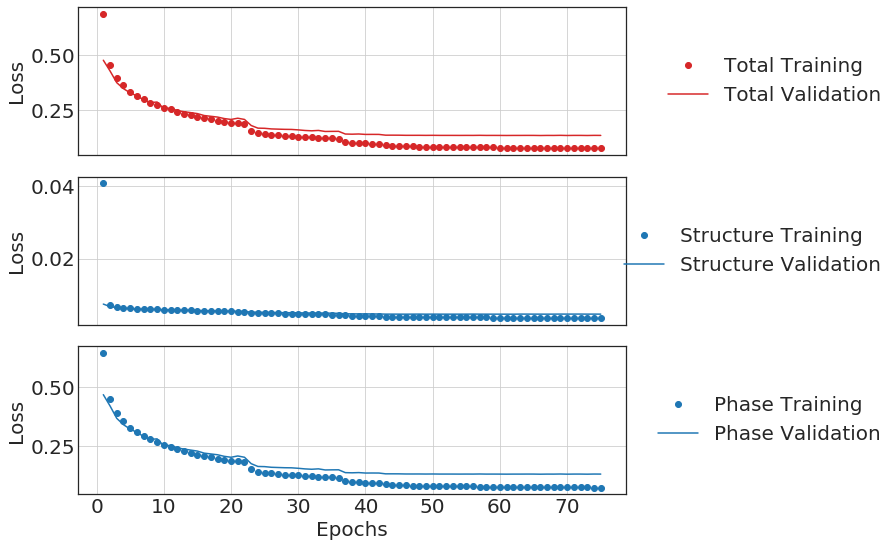

In [13]:
hist=history
epochs=np.asarray(history.epoch)+1

%matplotlib inline
import matplotlib
plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 20

f, axarr = plt.subplots(3, sharex=True, figsize=(12, 8))

axarr[0].set(ylabel='Loss')
axarr[0].plot(epochs,hist.history['loss'], 'C3o', label='Total Training')
axarr[0].plot(epochs,hist.history['val_loss'], 'C3-', label='Total Validation')
axarr[0].grid()
axarr[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

axarr[1].set(ylabel='Loss')
axarr[1].plot(epochs,hist.history['conv2d_13_loss'], 'C0o', label='Structure Training')
axarr[1].plot(epochs,hist.history['val_conv2d_13_loss'], 'C0-', label='Structure Validation')
axarr[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.xlabel('Epochs')
plt.tight_layout()
axarr[1].grid()


axarr[2].set(ylabel='Loss')
axarr[2].plot(epochs,hist.history['conv2d_20_loss'], 'C0o', label='Phase Training')
axarr[2].plot(epochs,hist.history['val_conv2d_20_loss'], 'C0-', label='Phase Validation')
axarr[2].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()
axarr[2].grid()


In [14]:
np.save('str_history', history.history)

### Save the epoch with the lowest validation loss
(PtychoNN will use these weights)

In [15]:
val_losses=hist.history['val_loss']
min_epoch=np.argmin(val_losses)+1
print (min_epoch)
np.save('%s/min_epoch' %(wt_path), min_epoch)

66
